## Backgound
Analysis of the Chemotaxis model described by Spiro et al., PNAS, 1999.
The model describes the receptor state along 3 dimensions:
  - bound to a ligand
  - phosphorylated
  - degree of methylation (considers 2, 3, 4)
  
Key variables are:
   - Y, Yp - concentrations of CheY and its phosphorylated form
   - B, Bp - concentrations of CheB and its phosphorylated form
   - L - ligand concentration
   - f<state>, t<state> - "f" indicates the fraction of the concentration in the state, "t" is the total
     <state> is a 3 character string, such as "TT2". T/F indicates the boolean value; the last is an integer.
     
Below is a figure from Spiro describing the state structure of receptors.

Issues
 - yaxis labels are not showing
 - Overshoot steady state YP
 - Not getting correct time response for YP

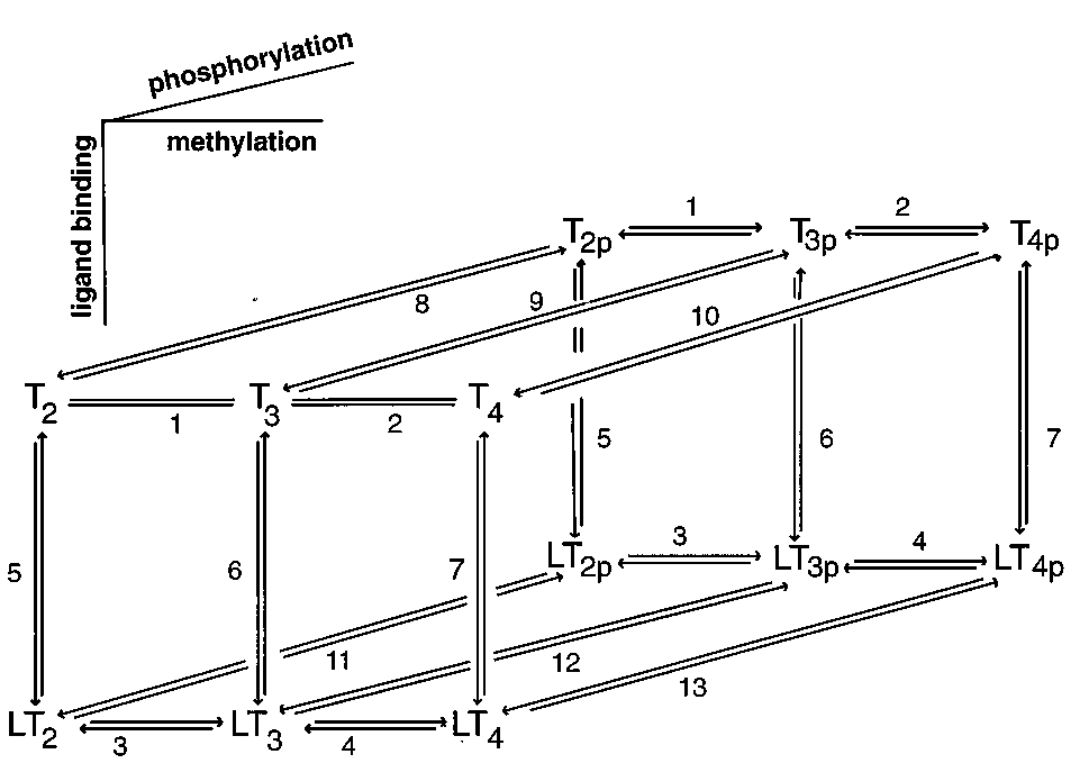

In [223]:
from IPython.display import Image, display
display(Image(filename='img/receptor_states.png'))

## Summary

Initially, we consider a step response. Later, we repeat the same analysis for a ramp. These correspond to the analyses done by Spiro.

Most of the analysis is done using fractional concentrations (variables that begin with "f"). We begin by justifying this.

Next, we analyze the effects of a step response. "Perfect adaptation" is possible if the step is small enough.

## Software Dependencies
The model and various utility functions are in the python modules chemotaxis_model and data_plotter.

In [224]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel, StateAggregationFactory
from data_plotter import DataPlotter
model = ChemotaxisModel()

## Antimony Model

In [225]:
print model.getModel()

# Template file for the Spiro model of chemotaxis in PNAS, 1999.
# The species B, R, T2, R, Y are specified separately.
#! SbStar Vesion 1.0 {'l': ['L', ''], 'm': ['2', '3', '4'], 'p': ['P', ''], 'r': ['R', '']} 
J0: $x0 -> L; k0*x0
# REACTIONS from Spiro, Table 3
# Methylation
J1_2{p}R: T2{p}R -> T3{p} + R; k1c*T2{p}R
J1_3{p}R: T3{p}R -> T4{p} + R; k2c*T3{p}R
J1_L2{p}R: LT2{p}R -> LT3{p} + R; k3c*LT2{p}R
J1_L3{p}R: LT3{p}R -> LT4{p} + R; k4c*LT3{p}R
# Demethylations.
J4a_3{p}{r}: T3{p}{r} + Bp -> T2{p}{r} + Bp; k_1*T3{p}{r}*Bp
J4b_4{p}{r}: T4{p}{r} + Bp -> T3{p}{r} + Bp; k_2*T4{p}{r}*Bp
J4c_L3{p}{r}: LT3{p}{r} + Bp -> LT2{p}{r} + Bp; k_3*LT3{p}{r}*Bp
J4d_L4{p}{r}: LT4{p}{r} + Bp -> LT3{p}{r} + Bp; k_4*LT4{p}{r}*Bp
#   Details of *T* + R <-> *T*R
J2_{l}{m}{p}: {l}T{m}{p}R -> {l}T{m}{p} + R; k1a*{l}T{m}{p}R
J3_{l}{m}{p}: {l}T{m}{p} + R -> {l}T{m}{p}R; k1b*{l}T{m}{p}*R
# Ligand binding and unbinding
J5_{m}{p}{r}: L + T{m}{p}{r} -> LT{m}{p}{r}; k5*L*T{m}{p}{r}
J6_{m}{p}{r}: LT{m}{p}{r} ->

## Common Codes Used in this Analysis

In [226]:
# Runs simulation and creates global variables used in analysis
def sim(elements=None,end=400, concentrations={}):
    """
    Runs the simulation and creates global names
    :param list elements: additions to model
    :param int end: simulation end time
    :param dict concentrations: key is variable, value is assignment
    Output: global variables - plotter, result
    """
    if elements is None:
      elements = []
    global plotter, result, model, rr
    model = ChemotaxisModel()
    for element in elements:
      model.appendToModel(element)
    rr = model.initialize()
    for k,v in concentrations.items():
      rr[k] = v
    result = model.run(end=end)
    plotter = DataPlotter(model)


In [227]:
# Export the XML
f_sbml = "chemotaxis.xml"
# export current model state
rr.exportToSBML(f_sbml)
# to export the initial state when the model

## Justification for Fractional Concentrations

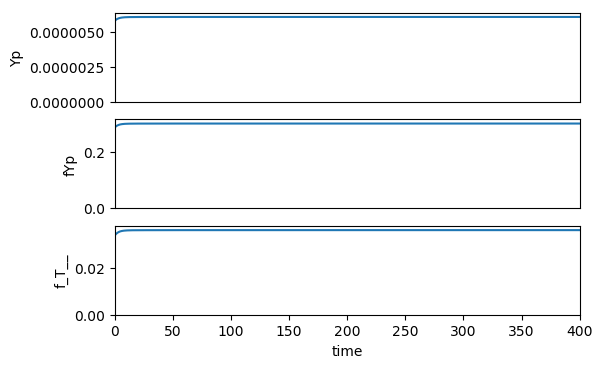

In [228]:
# Analysis for L = 0
sim()
plotter.lines(["Yp", "fYp", "f_T__"])

Observations
- Although the scales differ, the shape of Yp and fYp are identical.
- The Yp response corresponds to the shape of the fraction of methylated receptor

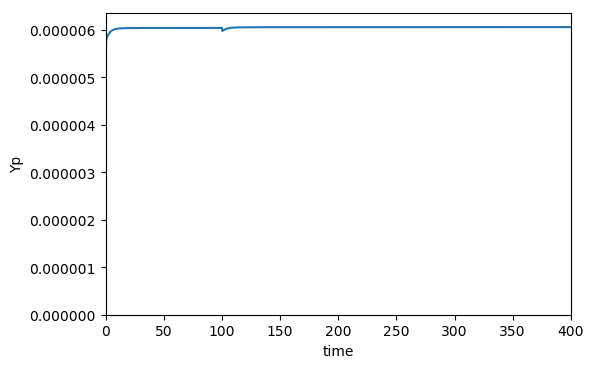

In [229]:
# Step Analysis for a change at 100
sim(elements=["at (time > 100): L = 0.11e-6"])
plotter.lines(["Yp"])

In [230]:
result['R']

array([  3.00000000e-07,   8.80040697e-11,   9.56399052e-11, ...,
         1.23207053e-10,   1.23207038e-10,   1.23207023e-10])

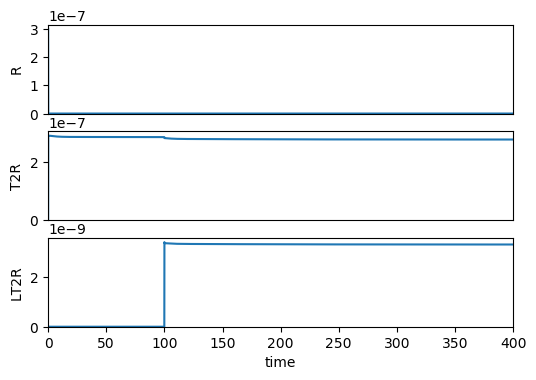

In [231]:
plotter.lines(["R", "T2R", "LT2R"])

Observations
- Why are there negative values of R

## Analysis of Step Response
The goal here is to understand the dynamics of the receptor state for a step response.
From the foregoing, we established that it's sufficient to look at the fraction of receptors that are in the phosphorylated state (since this correlates with Yp). Now we want to understand what substates contribute to phosphorylated receptors.

Spiro shows a step response plot with L going from 0 to 11uM and "perfect adaption of Yp. We do not see this. Possibly, this is because he used a model with more methylation levels. Below is Spiro's step response curve.

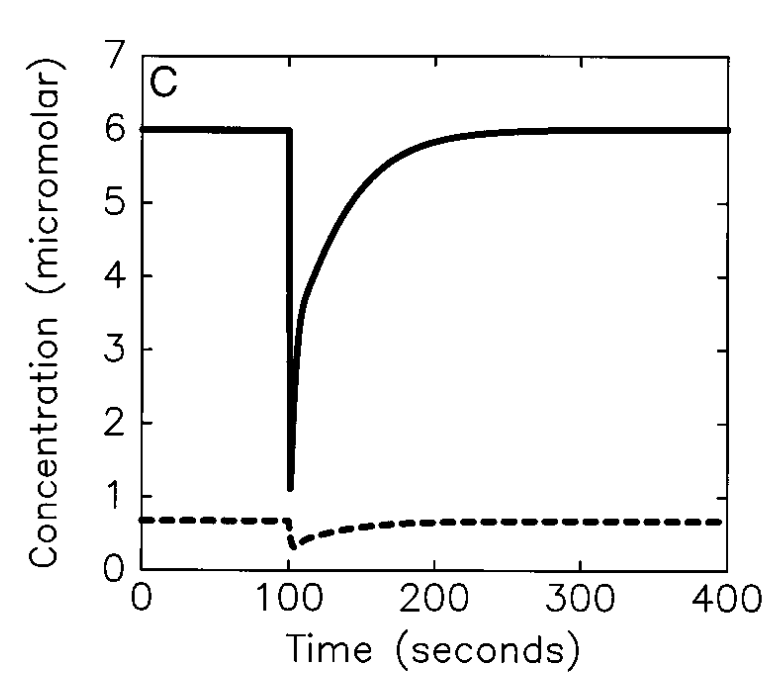

In [232]:
from IPython.display import Image, display
display(Image(filename='img/spiro_largestep.png'))

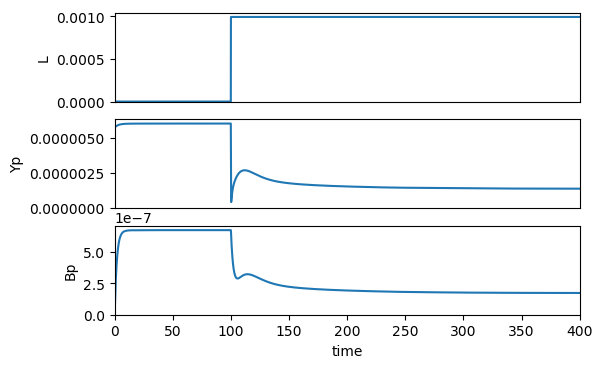

In [233]:
# The amount of ligand is 1000 times the amount of receptors
sim(elements=["at (time > 100): L = 1e-3"])
plotter.lines(["L", "Yp", "Bp"])

Response to a step input of L = 0.11e-6 at time 10

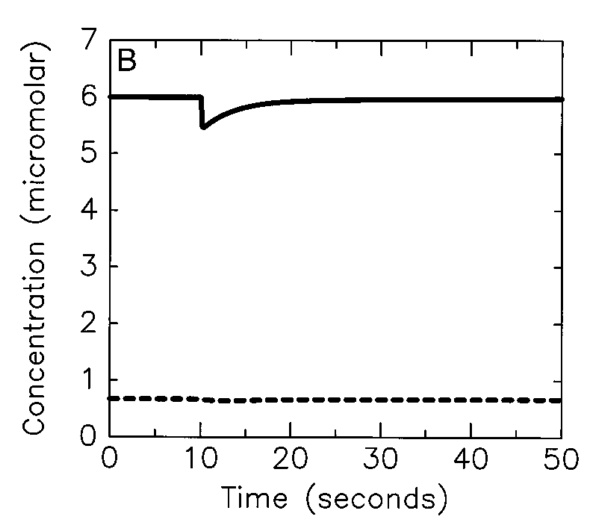

In [234]:
from IPython.display import Image, display
display(Image(filename='img/spiro_0.11.png'))

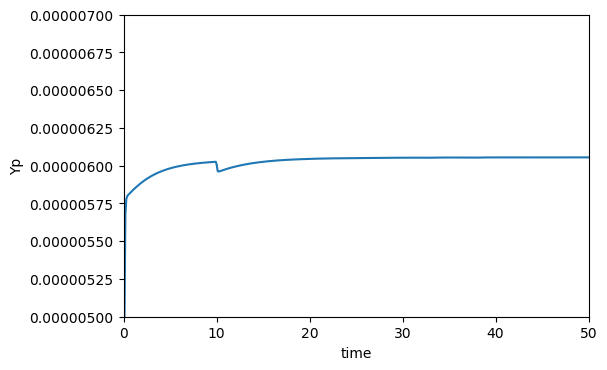

In [235]:
# What is the simulated step response for our model that corresponds to the Spiro?
# The solid line above is Yp and the dashed line is Bp; ligand concentration change is not shown.
sim(elements=["at (time > 10): L = 0.11e-6"], end=50)
plotter.lines(["Yp"], yrange=[5e-6,7e-6])

Observations
 - Gain is correct. Steady state value of Yp = 6e-6
 - Time constant of disturbance seems about right
 - Magnitude of the disturbance is somewhat less than Spiro (which drops to about 5.5e-6)

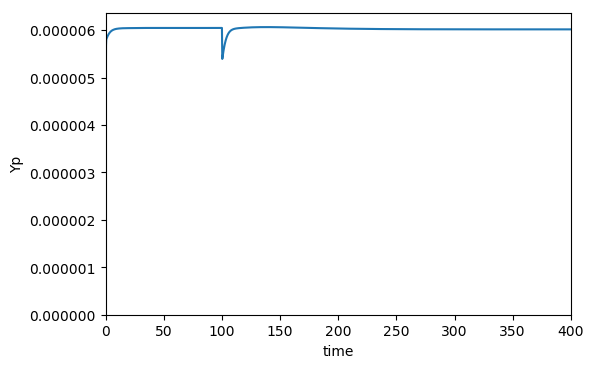

In [236]:
# Adjusting R gives a good response to a step
sim(elements=["at (time > 100): L = 1.1e-6"])
plotter.lines(["Yp"])

Observations
- Gain is correct. Steady state value of Yp = 6e-6
- returns to steady state of 6uM
- Magnitude of the disturbance is larger than adding L=11uM, as expected.

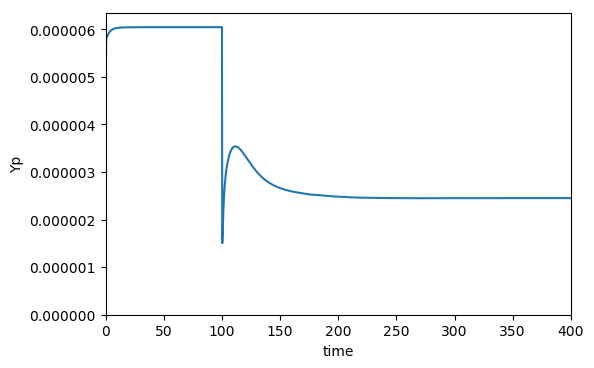

In [237]:
# System is flooded with more ligand than there are receptors
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["Yp"])

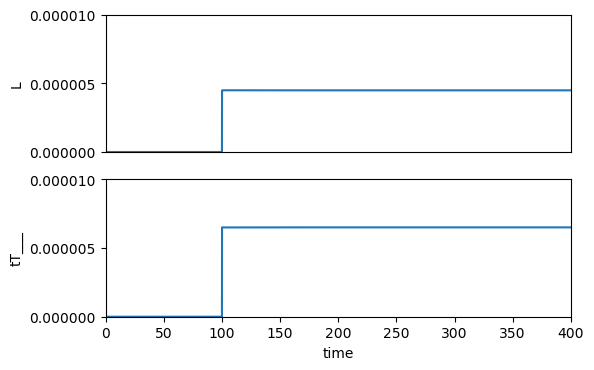

In [238]:
# Where does the ligand go?
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["L", "tT___"], yrange=[0, 10e-6])

Observations
- There are 8uM of receptors and we add 11uM of ligand. We end up with 6uM of bound receptors, and the rest is free Ligand. 
- k_on = k5 = 7e7; k_off = k_5 = 70. But since k_on is bimolecular, the reaction rate is much slower than the mono-molecular reverse reaction.

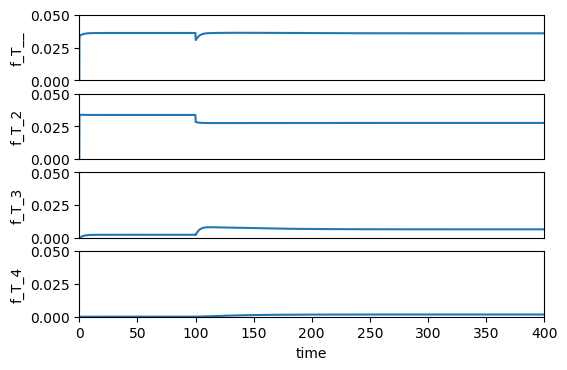

In [239]:
# Breakdown the state phosphorylation state by methylation level
sim(elements=["at (time > 100): L = 1.1e-6"])
plotter.lines(["f_T__", "f_T_2", "f_T_3", "f_T_4"], yrange=[0,0.05])

Observations
 - Phosphorylation level of receptor does not recover after the Ligands are introduced.

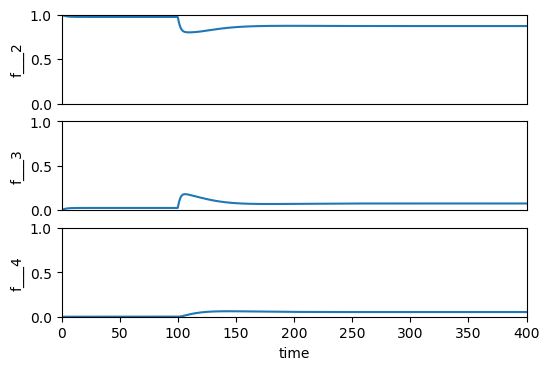

In [240]:
# Analyze the methylation levels
sim(elements=["at (time > 100): L = 4.1e-6"])
plotter.lines(["f___2", "f___3", "f___4"], yrange=[0,1])

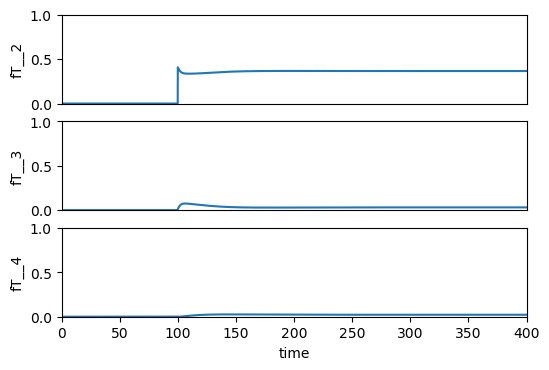

In [241]:
# Analyze the methylation levels for ligand bound receptors
sim(elements=["at (time > 100): L = 4.1e-6"])
plotter.lines(["fT__2", "fT__3", "fT__4"], yrange=[0,1])

Observations
- Large fraction of LT2 means reduced phosphorylation

Questions
- Why doesn't the LT2 methylate?

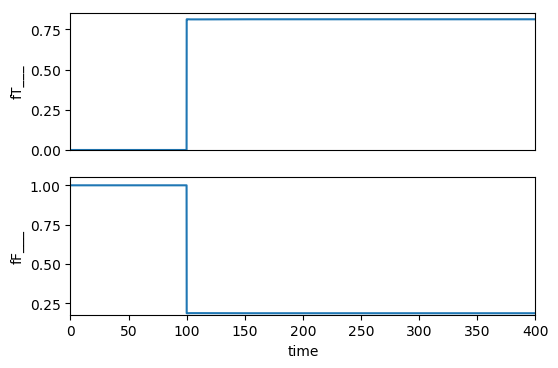

In [242]:
# 
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["fT___", "fF___"])

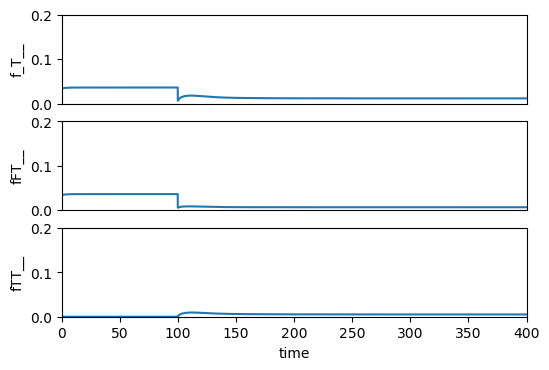

In [243]:
# Breakdown the state phosphorylations by ligand bound
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T__", "fFT__", "fTT__"], yrange=[0, 0.2])

Observations
- Most of the phosphorylation after the step is in receptors with the ligand bound

## Ramp analysis

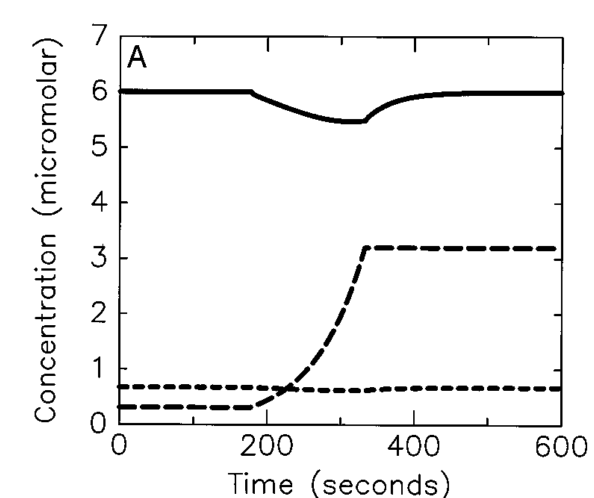

In [244]:
from IPython.display import Image, display
display(Image(filename='img/spiro_ramp.png'))

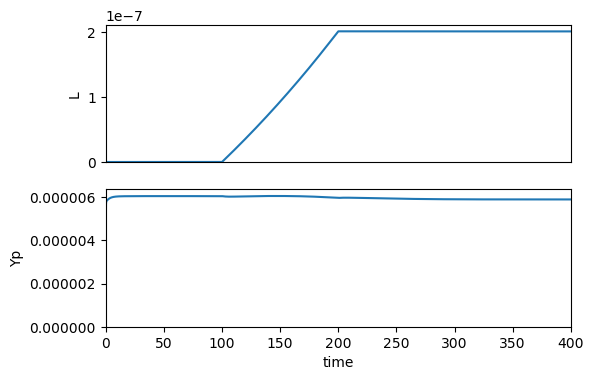

In [245]:
# Where does the ligand go?
elements = ["at (time > 100): k0 = 0.015e-6", "at (time > 200): k0 = 0, L=0.2e-6"]
sim(elements=elements)
plotter.lines(["L", "Yp"])

Observations
- Adapatation to a ramp is barely perceptable.
- Adaptation is much better than Spiro


# Conclusions

- Get results comparable to Spiro for ligand concentrations ~20% of receptor concentration, both for step and ramp.
- For ligand flooding (1000 times receptor concentration), do not get the Spiro results.